# Assignment 2

## Guidelines

> Remember to add an explanation of what you do using markdown, and to comment your code. Please *be brief*.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> Make sure your notebooks have been run when you sumit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.

## Grading policy
> As follows:
>
> * 70 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious.
> 
> * 10 points for doing something extra, e.g., if you go beyond expectations (overall or on something specific). Some ideas for extras might be mentioned in the exercises, or you can come up with your own. You don't need to do them all to get the bonus. The sum of points is 90, doing (some of) the extras can bring you to 100, so the extras are not necessary to get an A.
> 

**The AUC code of conduct applies to this assignment: please only submit your own work.**

---

# Introduction

In this assignment, you will build and compare vector models for measuring **semantic similarity**.

First, you are going to use different count-based methods to create these models. Secondly you are going to created dense, lower-dimensionality models from them. Thirdly, you are going to use prediction-based models as well.

Eventually, you are asked to assess the performance of these models against a human gold standard.

---

# Corpus preparation (10 points)

## Question 1 (10 points)

Create one distributional space by **counting and filtering** the surface co-occurrences in a symmetric ±5 word collocations span from the following corpus:

* A lemmatized version of the Reuters corpus (the choice of the lemmatizer is up to you). For this step, you might need a PoS-tagger: you are welcome to choose one yourself. In case you can't do PoS tagging on your own, you can use the following command to load the provided corpus in `data/reuters.pos` (uploaded as a `.zip` file, so first unzip it):

```python
with open("data/reuters.pos", "rb") as corpus_file:
    reuter_PoSTagged = pickle.load(corpus_file)
```

Remember to make motivated choices for the different strategies in building word vectors as described in class. Be explicit about:

1. what lemmas you want to describe (i.e., what will be your target vectors?);
2. how you want to describe them (i.e., what will be your contexts?);
3. what filtering strategy you are going to choose (i.e., what do you exclude?).

In [2]:
import nltk
import string
from nltk.corpus import reuters
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

sentences = reuters.raw().lower().split(". ")

regextk = RegexpTokenizer('\s+', gaps = True)

tok_sents = [regextk.tokenize(s) for s in sentences]

tagged = [nltk.pos_tag(sent) for sent in tok_sents]


def wn_pos(tag):
    "converts treebank tags into wordbank tags for lemmatization"
    if tag.startswith('J'):
        return wn.ADJ
    
    if tag.startswith('V'):
        return wn.VERB
    
    if tag.startswith('N'):
        return wn.NOUN
    
    if tag.startswith('R'):
        return wn.ADV
    
    return None

lem_sents = []
lem = WordNetLemmatizer()

for sent in tagged:
    lemmas = []
    for word, tag in sent:
        try:
            wn_tag = wn_pos(tag)
            if word[0] in string.punctuation:
                word = word[1:]
            if word[-1] in string.punctuation:
                word = word[:-1]
            if wn_tag is None:
                # append lemmatized word to list
                lemmas.append((lem.lemmatize(word), wn_tag))
            else:
                # use PoS tag for more accurate lemmatization
                lemmas.append((lem.lemmatize(word, wn_tag), wn_tag))
        except IndexError:        
            pass
        
    lem_sents.append(lemmas)

lemmas = [lem for sentence in lem_sents for lem in sentence]

# arbitrary lemmatized sentence as an example
lem_sents[10]

[('much', 'r'),
 ('more', 'r'),
 ('serious', 'a'),
 ('for', None),
 ('hong', 'n'),
 ('kong', 'n'),
 ('be', 'v'),
 ('the', None),
 ('disadvantage', 'n'),
 ('of', None),
 ('action', 'n'),
 ('restrain', 'v'),
 ('trade,', 'n'),
 ('he', None),
 ('say', 'v'),
 ('the', None),
 ('u.s', 'n')]

Above is now a lemmatized version of the reuters corpus, which can be split by sentence or treated as a huge list of words

In [ ]:
# compact alternate implementation with spacy
# DO NOT RUN - USES TOO MUCH MEMORY

import spacy
from nltk.corpus import reuters

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 10_000_000

doc = nlp(reuters.raw().lower())

reuters_lemmatized = [token.lemma_ for token in doc]

In [5]:
from itertools import permutations
from collections import Counter

spansize = 5
cooccs_surface = Counter()

for i, w in enumerate(lemmas):
    if len(w) > 1:
        span_range = list(range(max(i- spansize, 0), i))
        span_range.extend(range(i+1, min(i + spansize + 1, len(lemmas))))
        for cw in [lemmas[idx] for idx in span_range]:
            cooccs_surface[(w, cw)] += 1
        
cooccs_surface.most_common(10)

[((('the', None), ('the', None)), 28198),
 ((('of', None), ('the', None)), 26053),
 ((('the', None), ('of', None)), 26053),
 ((('the', None), ('to', None)), 18468),
 ((('to', None), ('the', None)), 18468),
 ((('in', None), ('the', None)), 17600),
 ((('the', None), ('in', None)), 17600),
 ((('the', None), ('be', 'v')), 17523),
 ((('be', 'v'), ('the', None)), 17523),
 ((('say', 'v'), ('the', None)), 16812)]

As can be seen above, checking word co-occurances in a `±5 word span` within the text returns some less-than-interesting results. 

Let's do the same again but filter for **only nouns**, as this should return some more interesting connections

In [6]:
noun_cooccs = Counter()

for i, w in enumerate(lemmas):
    if w[1] == "n":
        span_range = list(range(max(i- spansize, 0), i))
        span_range.extend(range(i+1, min(i + spansize + 1, len(lemmas))))
        for cw in [lemmas[idx] for idx in span_range]:
            noun_cooccs[(w, cw)] += 1
        
noun_cooccs.most_common(10)

[((('mln', 'n'), ('mln', 'n')), 10416),
 ((('mln', 'n'), ('v', 'n')), 9346),
 ((('v', 'n'), ('mln', 'n')), 9346),
 ((('ct', 'n'), ('vs', 'a')), 6787),
 ((('ct', 'n'), ('ct', 'n')), 6500),
 ((('ct', 'n'), ('net', 'a')), 5972),
 ((('company', 'n'), ('the', None)), 4875),
 ((('loss', 'n'), ('vs', 'a')), 4160),
 ((('loss', 'n'), ('loss', 'n')), 3832),
 ((('dlrs', 'n'), ('mln', 'n')), 3581)]

This corpus contains a lot of dense numerical information, meaning high rates of co-occurances for unusual strings like `"dlrs", "mln", "ct", and "vs"`.

**We'll have to filter this quite a bit**

In [78]:
from itertools import chain
from nltk.corpus import stopwords

filtered = []
nouns = []
freqs = nltk.FreqDist(lemmas)
stops = set(stopwords.words('english'))
odd = "mln ct v dlrs pct net vs shr".split()

for word in lemmas:
    if (freqs[word] >= 10 and 
        word[0] not in stops and
        word[0] not in odd and
        word[1] != None):
        filtered.append(word)
        if word[1] == "n":
            nouns.append(word)
            
filt_fd = nltk.FreqDist(filtered)
noun_fd = nltk.FreqDist(nouns)

filt_fd.most_common(10)

[(('say', 'v'), 24189),
 (('year', 'n'), 6612),
 (('share', 'n'), 5489),
 (('loss', 'n'), 5486),
 (('company', 'n'), 4771),
 (('bank', 'n'), 4295),
 (('price', 'n'), 3806),
 (('u.s', 'n'), 3588),
 (('profit', 'n'), 3374),
 (('market', 'n'), 3371)]

There's a much nicer frequency distribution of words!

I chose to remove all **stopwords** as well as a list of unusual financial-related words that appeared commonly.

I also only kept words that have been PoS tagged - meaning just *nouns, verbs, adjectives, and adverbs*

In [79]:
filtered_cooccs_surface = Counter()

for word, freq in cooccs_surface.items():
    if word[0] in noun_fd and word[1] in filt_fd:
        filtered_cooccs_surface[word] = freq

filtered_cooccs_surface.most_common(10)

[((('loss', 'n'), ('loss', 'n')), 3832),
 ((('profit', 'n'), ('loss', 'n')), 2164),
 ((('loss', 'n'), ('profit', 'n')), 2164),
 ((('company', 'n'), ('say', 'v')), 2109),
 ((('bank', 'n'), ('say', 'v')), 1226),
 ((('loss', 'n'), ('rev', 'n')), 1111),
 ((('rev', 'n'), ('loss', 'n')), 1111),
 ((('year', 'n'), ('last', 'a')), 1036),
 ((('corp', 'n'), ('say', 'v')), 976),
 ((('profit', 'n'), ('profit', 'n')), 946)]

---

# Vector representations (60 points)

## Question 2 (20 points)

Weight the counts in the space you created for the previous question by using the following association measures on both spaces:

1. One **measure of your choice** among those available in the [nltk.BigramAssocMeasures](http://www.nltk.org/howto/metrics.html#association-measures) module.
2. The **Positive Local Mutual Information** measure (as shown in class/lab).

**Possible extra**

3. Also use the **smoothed ppmi measure** proposed by [Levy et al. (2015)](http://www.aclweb.org/anthology/Q15-1016). Recall that the authors proposed to smooth the ppmi by raising the context counts to the power of $\alpha$ (where $\alpha= 0.75$ is reported to work well). That is, if $V_c$ is the vocabulary of all the contexts in a given space and $f(c)$ is the context frequency, they proposed the following association measure:

$$PPMI_\alpha (w,c) = max \left(0, \ log_2 \left(\frac{p(w,c)}{p(w) \cdot p_\alpha(c)}\right)  \right) $$

$$where: \ \ p_\alpha(c) = \frac{f(c)^\alpha}{\sum_{c' \in V_c} f(c')^\alpha}$$

In [152]:
# your code here

from nltk.collocations import (BigramAssocMeasures as bam, 
                               BigramCollocationFinder as bcf)

# search for strict bigrams (span 2)
finder = bcf.from_words(filtered, window_size=2)
finder.apply_freq_filter(10)
chi_scored = finder.score_ngrams(bam.chi_sq)

chi_scored[:10]

[((('corpus', 'n'), ('christi', 'n')), 653329.0),
 ((('wk', 'v'), ('named-a', 'a')), 653329.0),
 ((('ttl-f', 'a'), ('usdaprj-g', 'a')), 593934.5454406304),
 ((('karl', 'n'), ('otto', 'n')), 581664.7434793665),
 ((('lufkin', 'n'), ('jenrette', 'n')), 559994.5713970838),
 ((('bra', 'n'), ('kanon', 'n')), 559992.8570169042),
 ((('poison', 'n'), ('pill', 'n')), 525771.6285160262),
 ((('costa', 'n'), ('rica', 'n')), 487291.86140952766),
 ((('brace', 'n'), ('jovanovich', 'n')), 435545.9997959108),
 ((('burnham', 'n'), ('lambert', 'n')), 431711.11590458115)]

In [148]:
from math import log

def ppmi(o_11, r_1, c_1, n):
    "Positive Pointwise Mutual Information (Church & Hanks, 1990)"
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

def plmi(o_11, r_1, c_1, n):
    "Positive Local Mutual Information, useful for leveraging the low-frequency bias of the PPMI"
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res

plmis_surface = Counter()

N = sum(cooccs_surface.values())

for words, freq in filtered_cooccs_surface.items():
    plmis_surface[words] = plmi(freq, freqs[words[0]], freqs[words[1]], N)
    
plmis_surface.most_common(10)

[((('loss', 'n'), ('loss', 'n')), 41293.756528189544),
 ((('profit', 'n'), ('loss', 'n')), 23052.940700843934),
 ((('loss', 'n'), ('profit', 'n')), 23052.940700843934),
 ((('company', 'n'), ('say', 'v')), 16820.18686030617),
 ((('loss', 'n'), ('rev', 'n')), 11428.373852315883),
 ((('rev', 'n'), ('loss', 'n')), 11428.373852315883),
 ((('year', 'n'), ('last', 'a')), 9725.836218613771),
 ((('profit', 'n'), ('profit', 'n')), 9611.772760273878),
 ((('bank', 'n'), ('say', 'v')), 9004.31507699253),
 ((('state', 'n'), ('united', 'a')), 7825.757078502919)]

In [149]:
def sppmi(o_11, r_1, c_1, n):
    "Smoothed PPMI with context counts raised to the power a = 0.75"
    p = c_1/n
    a = 0.75
    pac = (p ** a) / (p ** a + (1 - p) ** a)
    exp = (r_1/n) * pac
    res = log(o_11 / exp, 2)
    return max(0, res)

sppmis_surface = Counter()

for words, freq in filtered_cooccs_surface.items():
    sppmis_surface[words] = sppmi(freq, freqs[words[0]], freqs[words[1]], N)
    
sppmis_surface.most_common(10)

[((('het', 'n'), ('comite', 'n')), 39.14774236628333),
 ((('comite', 'n'), ('het', 'n')), 39.14774236628333),
 ((('corpus', 'n'), ('christi', 'n')), 38.72636269329684),
 ((('christi', 'n'), ('corpus', 'n')), 38.72636269329684),
 ((('pill', 'n'), ('poison', 'n')), 38.6710650014388),
 ((('poison', 'n'), ('pill', 'n')), 38.64617870882526),
 ((('lufkin', 'n'), ('jenrette', 'n')), 38.64617870882526),
 ((('jenrette', 'n'), ('lufkin', 'n')), 38.59057571801638),
 ((('siegler', 'n'), ('lear', 'a')), 38.49207628096376),
 ((('hajime', 'n'), ('tamura', 'n')), 38.436104773522466)]

---

## Question 3 (20 points)

Up to this point, you should have created 2 different distributional spaces (3 if you did the extra).

Use **Singular Value Decomposition** to reduce their dimensionality retaining only the first 100 dimensions. For this question, you can either re-use the SVD code from the lab, or import the SVD functions from external libraries such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) or [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html).

**Possible extra**

Find the 'optimal' number of dimensions to retain using the approach shown in the lab. Use a model with this dimensionality instead of 100.

In [165]:
# your code here
import sklearn
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# lemma to row/column index mappings
sorted_vectors = sorted(noun_fd)
vectors_indices = dict((v,i) for i,v in enumerate(sorted_vectors))
contexts_indices = dict((v,i) for i,v in enumerate(sorted(filt_fd)))


# create matrix to store PLMI values
plmiMat = np.zeros((len(vectors_indices), len(contexts_indices)))
for pair, weight in plmis_surface.items():
    plmiMat[vectors_indices[pair[0]]][contexts_indices[pair[1]]] = weight
    

# create matrix to store Smoothed PPMI values
sppmiMat = np.zeros((len(vectors_indices), len(contexts_indices)))
for pair, weight in sppmis_surface.items():
    sppmiMat[vectors_indices[pair[0]]][contexts_indices[pair[1]]] = weight

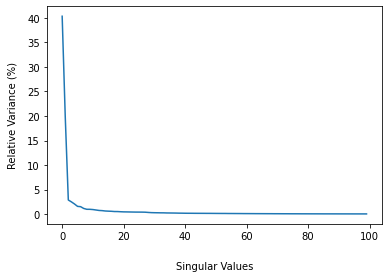

In [164]:
from scipy import linalg, dot
import matplotlib.pyplot as plt

U, s, Vt = linalg.svd(plmiMat)

if not U[U>0].size > (U.size / 2):
    U = -U
    Vt = -Vt
    
rel_variance = ( s**2 / sum(s**2) ) * 100

y_values =  rel_variance[:100] 
x_values = np.arange(len(y_values))

plt.plot(x_values, y_values, linestyle = '-')

plt.xlabel("Singular Values", labelpad = 20)
plt.ylabel("Relative Variance (%)", labelpad = 10)

plt.show()

Judging from the above plot, the relative variance percentage really drops off between 10 and 20 dimensions.

I'll stick with **20** dimensions for SVD from here on, as to make sure little information is lost

In [273]:
dim = 20

k = 5
target_idx = vectors_indices[("year", "n")] 

plmi_svd = TruncatedSVD(n_components=dim).fit_transform(plmiMat)
plmi_cos_sim = cosine_similarity(plmi_svd)

print("word vectors most similar to 'year' according to the plmi space:\n")

for idx in plmi_cos_sim[target_idx,].argsort()[::-1][1:k+1]:
    print(sorted_vectors[idx], plmi_cos_sim[target_idx, idx])

word vectors most similar to 'year' according to the plmi space:

('month', 'n') 0.9248842642775666
('cathay', 'n') 0.9003143348664894
('september', 'n') 0.8878204686710206
('autumn', 'n') 0.8875817946102142
("year's", 'n') 0.8863390215581793


In [274]:
sppmi_svd = TruncatedSVD(n_components=dim).fit_transform(sppmiMat)
sppmi_cos_sim = cosine_similarity(sppmi_svd)

print("word vectors most similar to 'year' according to the sppmi space:\n")

for idx in sppmi_cos_sim[target_idx,].argsort()[::-1][1:k+1]:
    print(sorted_vectors[idx], sppmi_cos_sim[target_idx, idx])

word vectors most similar to 'year' according to the sppmi space:

('sale', 'n') 0.9389758166785845
('company', 'n') 0.9267187841007433
('month', 'n') 0.9256464828241585
('u.s', 'n') 0.9187203066849902
('said', 'n') 0.9144199364175969


---

## Question 4 (20 points)

Train a Word2Vec model the same corpus, for example using [gensim](https://radimrehurek.com/gensim). Make sure to motivate the choice of your hyperparameters.

**Possible extra**

*Fine-tuning* is the process of starting from a pre-trained embedding model and training it some more using new data. Try to use a pre-trained model from gensim and to fine-tune it on the Reuters corpus.

In [109]:
# your code here
from gensim.models import Word2Vec
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100')

In [211]:
parameters = {
    'vector_size': 100, # same size as other spaces
    'alpha': 0.12, # initial learning rate for SGD - seems to produce best results
    'window': 5, # same collocation span as before
    'min_count': 5, # only take words with frequency > 5
    'workers': 4, # cpu cores
    'sg': 1, # implements skip-gram
    'epochs': 5 # iterations - 5 seemed reasonable
}

untagged_sents = []
for sent in lem_sents:
    untagged_sents.append([word for word, tag in sent])

# creating Word2Vec space for the list of untagged lemmatized sentences
lemma_w2v = Word2Vec(untagged_sents, **parameters)
print(lemma_w2v)

Word2Vec(vocab=11401, vector_size=100, alpha=0.12)


In [218]:
# fine-tuning pretrained model onto the reuters corpus
tuned_w2v = Word2Vec(vector_size=100, min_count=1)
tuned_w2v.build_vocab(untagged_sents)

tuned_w2v.build_vocab(list(wv.index_to_key), update=True)
tuned_w2v.train(untagged_sents, total_examples=tuned_w2v.corpus_count, epochs=tuned_w2v.epochs)
print(tuned_w2v)

Word2Vec(vocab=55520, vector_size=100, alpha=0.025)


In [220]:
tuned_w2v.wv.most_similar(["say"])

[('said', 0.6938016414642334),
 ('have', 0.6766988635063171),
 ('also', 0.665836751461029),
 ('the', 0.6245516538619995),
 ('be', 0.6065378785133362),
 ('add', 0.5915255546569824),
 ('that', 0.5855926871299744),
 ('tell', 0.5822742581367493),
 ('it', 0.5718165040016174),
 ('however', 0.5317421555519104)]

---

# Evaluating on semantic similarity (20 points)

## Question 5 (20 points)

Evaluate the performance of your models on a **semantic similarity task**. Using `SimLex-999` as gold standard. Evaluate all of your models on the dataset in `data/SimLex-999.txt`, and determine the best performing model. Note: There should be 5 to 8 model evaluations in total. 5 if you did not do any extra (2 from 4.1 + 2 from 4.2 + 1 from 4.3), and 8 if you did them all (3 from 4.1 + 3 from 4.2 + 2 from 4.3).

1. Your evaluation should follow the approach shown in lab 4 (Section 1.6: "Evaluating your Model"), using a **correlation measure** on model predictions and the (human) gold standard. 
2. Remember to **visualize** your results (e.g., as bar plots).
3. Take note (and report) the overlap between your models and the SimLex-999 dataset, i.e., how many pairs are shared by your model and the evaluation dataset.
4. Make sure to discuss your results and provide your reasoning on them.

### Remarks

- The 'SimLex-999' dataset is described in `data/SimLex-999.README.txt`, and [the author's github page](https://fh295.github.io/simlex.html). Hint: the relevant judgements are those in the `SimLex999` column.
- To directly compare the models against the gold standard, you will have to find the *overlap* between them, i.e. the pairs that occur in your model *and* the evaluation dataset.

In [112]:
with open("data/SimLex-999.txt") as f:
    for n, line in enumerate(f.read().split("\n")):
        items = line.split("\t")
        print(items)
        if n>10:
            break

['word1', 'word2', 'POS', 'SimLex999', 'conc(w1)', 'conc(w2)', 'concQ', 'Assoc(USF)', 'SimAssoc333', 'SD(SimLex)']
['old', 'new', 'A', '1.58', '2.72', '2.81', '2', '7.25', '1', '0.41']
['smart', 'intelligent', 'A', '9.2', '1.75', '2.46', '1', '7.11', '1', '0.67']
['hard', 'difficult', 'A', '8.77', '3.76', '2.21', '2', '5.94', '1', '1.19']
['happy', 'cheerful', 'A', '9.55', '2.56', '2.34', '1', '5.85', '1', '2.18']
['hard', 'easy', 'A', '0.95', '3.76', '2.07', '2', '5.82', '1', '0.93']
['fast', 'rapid', 'A', '8.75', '3.32', '3.07', '2', '5.66', '1', '1.68']
['happy', 'glad', 'A', '9.17', '2.56', '2.36', '1', '5.49', '1', '1.59']
['short', 'long', 'A', '1.23', '3.61', '3.18', '2', '5.36', '1', '1.58']
['stupid', 'dumb', 'A', '9.58', '1.75', '2.36', '1', '5.26', '1', '1.48']
['weird', 'strange', 'A', '8.93', '1.59', '1.86', '1', '4.26', '1', '1.3']
['wide', 'narrow', 'A', '1.03', '3.06', '3.04', '2', '4.06', '1', '0.58']


In [275]:
# your code here

import pandas as pd

sim_array = []

with open("data/SimLex-999.txt") as f:
    lines = f.read().split("\n")
    for line in lines:
        sim_array.append(line.split("\t"))
    
# organising data to make it easy to compare to later
df = pd.DataFrame(sim_array, columns=(sim_array[0])).drop(index=[0,1000])

# dropping redundant columns from the data
df = df.drop(columns=['POS', 'conc(w1)', 'conc(w2)', 'concQ','Assoc(USF)', 'SimAssoc333', 'SD(SimLex)'])
df

,word1,word2,SimLex999
1,old,new,1.58
2,smart,intelligent,9.2
3,hard,difficult,8.77
4,happy,cheerful,9.55
5,hard,easy,0.95
...,...,...,...
995,join,acquire,2.85
996,send,attend,1.67
997,gather,attend,4.8
998,absorb,withdraw,2.97


In [236]:
# the next two functions are horribly inefficient but they work and I didn't have time to re-write

plmi_overlaps = []

for pair, score in plmis_surface.items():
    new_pair = (pair[0][0], pair[1][0])
    if new_pair in list(zip(df["word1"], df["word2"])):
        try:
            sim = plmi_cos_sim[vectors_indices[pair[0]], vectors_indices[pair[1]]]
            plmi_overlaps.append((pair[0][0], pair[1][0], round(10 * sim, 2)))
        except KeyError:
            pass
        
plmi_overlaps[:10]

[('dollar', 'people', 8.24),
 ('tin', 'metal', 8.52),
 ('business', 'company', 9.06),
 ('tax', 'income', 8.44),
 ('pact', 'agreement', 9.39),
 ('money', 'capital', 5.26),
 ('home', 'state', 2.1),
 ('fee', 'payment', 5.09),
 ('business', 'industry', 9.57),
 ('cereal', 'wheat', 8.88)]

In [239]:
sppmi_overlaps = []

for pair, score in sppmis_surface.items():
    new_pair = (pair[0][0], pair[1][0])
    if new_pair in list(zip(df["word1"], df["word2"])):
        try:
            sim = sppmi_cos_sim[vectors_indices[pair[0]], vectors_indices[pair[1]]]
            sppmi_overlaps.append((pair[0][0], pair[1][0], round(10 * sim, 2)))
        except KeyError:
            pass
        
sppmi_overlaps[:10]

[('dollar', 'people', 8.16),
 ('tin', 'metal', 8.38),
 ('business', 'company', 8.92),
 ('tax', 'income', 9.09),
 ('pact', 'agreement', 9.16),
 ('money', 'capital', 8.73),
 ('home', 'state', 8.11),
 ('fee', 'payment', 8.69),
 ('business', 'industry', 9.46),
 ('cereal', 'wheat', 8.61)]

In [244]:
# much more efficient

w2v_overlaps = []
for w1, w2 in list(zip(df["word1"], df["word2"])):
    if w1 in lemma_w2v.wv and w2 in lemma_w2v.wv:
        w2v_overlaps.append((w1, w2, round(10 * lemma_w2v.wv.similarity(w1, w2), 2)))
        
w2v_overlaps[20:25]

[('nice', 'generous', 2.58),
 ('confident', 'sure', 4.99),
 ('large', 'big', 6.86),
 ('big', 'broad', 0.9),
 ('unnecessary', 'necessary', 3.53)]

In [245]:
tuned_w2v_overlaps = []
for w1, w2 in list(zip(df["word1"], df["word2"])):
    if w1 in tuned_w2v.wv and w2 in tuned_w2v.wv:
        tuned_w2v_overlaps.append((w1, w2, round(10 * tuned_w2v.wv.similarity(w1, w2), 2)))
        
tuned_w2v_overlaps[30:35]

[('impatient', 'anxious', 5.85),
 ('big', 'broad', 3.55),
 ('strong', 'proud', 3.07),
 ('unnecessary', 'necessary', 7.01),
 ('bad', 'great', 6.73)]

In [263]:
# creating dataframes for each space and merging into one

plmi_df = pd.DataFrame(plmi_overlaps, columns=["word1", "word2", "PLMI Space"])
sppmi_df = pd.DataFrame(sppmi_overlaps, columns=["word1", "word2", "Smoothed PPMI"])
w2v_df = pd.DataFrame(w2v_overlaps, columns=["word1", "word2", "Lemma W2V"])
tuned_df = pd.DataFrame(tuned_w2v_overlaps, columns=["word1", "word2", "Fine-Tuned W2V"])

merged = pd.merge(df, plmi_df, how="left", on=["word1", "word2"])
merged = pd.merge(merged, sppmi_df, how="left", on=["word1", "word2"])
merged = pd.merge(merged, w2v_df, how="left", on=["word1", "word2"])
merged = pd.merge(merged, tuned_df, how="left", on=["word1", "word2"])

disp = merged.dropna(subset=['PLMI Space', 'Smoothed PPMI',], thresh=2)
disp

,word1,word2,SimLex999,PLMI Space,Smoothed PPMI,Lemma W2V,Fine-Tuned W2V
115,south,north,2.2,7.09,9.42,4.84,6.61
134,area,region,9.47,9.36,8.97,5.46,7.85
135,navy,army,6.43,8.80,9.11,5.95,8.17
171,tax,income,2.38,8.44,9.09,4.90,5.06
174,floor,ceiling,1.73,8.26,8.64,2.72,4.31
195,business,industry,7.02,9.57,9.46,3.31,4.86
196,winter,season,6.27,8.86,9.45,4.98,7.83
200,window,door,3.33,3.34,6.29,2.78,2.46
228,metal,aluminum,7.25,8.73,9.40,4.25,7.54
234,attorney,lawyer,9.35,9.90,9.14,5.53,8.89


Clearly, many of the results provided by the PLMI measure are quite different to the human gold standard. This could be due to the relatively low size of the reuters corpus, as well as the lack of range in its vocabulary. 

The **Smoothed PPMI** space seems to give results closer to that of **SimLex999**, but tends to rate antonyms more closely than SimLex does, perhaps because they appear in similar contexts.

There are only 37 pairs of words that appear in both spaces, which is a tiny portion of the SimLex dataset.

However, both of the word2vec spaces overlap with more than **70%** of the SimLex data, providing many more useful insights.

Above I display only the **37** words which appear in all the spaces, but the rest are accessible in `merged`

In [276]:
from scipy.stats import spearmanr

rhos = []
for space in merged.columns[3:]:
    
    rho, pval = spearmanr(merged["SimLex999"], merged[space])
    rhos.append(rho)
    
print(rhos)

[0.13388256246422825, 0.13365393315276552, 0.15418280774238294, 0.15135564131845616]


The Spearman test results in very similar rho values for both the PLMI and Smoothed PPMI spaces, even though they give very different cosine similarities for most of the overlapping words.

Both of the Word2Vec models are good, with the fine-tuned one surprisingly performing slightly worse.

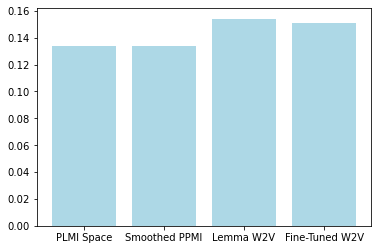

<Figure size 960x640 with 0 Axes>

In [270]:
plt.bar(range(0, len(rhos)), rhos, width=0.8, color="lightblue")
plt.xticks(range(0, len(rhos)), merged.columns[3:])
plt.figure(dpi=160)
plt.show()

---